In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [5]:
data_path = "data/fra.txt"

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().strip().split('\n')

print("Total lines in file:", len(lines)) 


sentence_pairs = []
for line in lines[:10000]:
    parts = line.split('\t')
    if len(parts) >= 2:
        sentence_pairs.append(parts[:2])

print("Valid sentence pairs:", len(sentence_pairs))  

input_texts, target_texts = zip(*sentence_pairs)
target_texts = ['<start> ' + sentence + ' <end>' for sentence in target_texts]

print("Sample input:", input_texts[0])
print("Sample target:", target_texts[0])





Total lines in file: 237838
Valid sentence pairs: 10000
Sample input: Go.
Sample target: <start> Va ! <end>


In [7]:
input_tokenizer = Tokenizer(filters='')
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)
input_tensor = pad_sequences(input_sequences, padding='post')

target_tokenizer = Tokenizer(filters='')
target_tokenizer.fit_on_texts(target_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)
target_tensor = pad_sequences(target_sequences, padding='post')

input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

print("Input tensor shape:", input_tensor.shape)
print("Target tensor shape:", target_tensor.shape)
print("Input vocab size:", input_vocab_size)
print("Target vocab size:", target_vocab_size)


Input tensor shape: (10000, 4)
Target tensor shape: (10000, 12)
Input vocab size: 2707
Target vocab size: 5572


In [8]:
from sklearn.model_selection import train_test_split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size=0.2)

print("Training samples:", len(input_tensor_train))
print("Validation samples:", len(input_tensor_val))


Training samples: 8000
Validation samples: 2000


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

embedding_dim = 256
lstm_units = 512

encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(input_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(lstm_units, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(target_vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(target_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, None, 256)         │         692,992 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, None, 256)         │       1,426,432 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 512), (None,      │       1,574,912 │ embedding[0][0]            │
│                               │ 512), (None, 512)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, None, 512),       │       1,574,912 │ embedding_1[0][0],         │
│                               │ (None, 512), (None, 512)] │                 │ lstm[0][1], lstm[0][2]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, None, 5572)        │       2,858,436 │ lstm_1[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 8,127,684 (31.00 MB)

 Trainable params: 8,127,684 (31.00 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
decoder_input_data = target_tensor_train[:, :-1]
decoder_target_data = target_tensor_train[:, 1:]
decoder_target_data = np.expand_dims(decoder_target_data, -1)

print("Decoder input shape:", decoder_input_data.shape)
print("Decoder target shape:", decoder_target_data.shape)


Decoder input shape: (8000, 11)
Decoder target shape: (8000, 11, 1)


In [13]:
history = model.fit(
    [input_tensor_train, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=10,
    validation_split=0.2
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 707ms/step - loss: 4.0583 - val_loss: 1.9576
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 750ms/step - loss: 1.8210 - val_loss: 1.7854
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 721ms/step - loss: 1.6075 - val_loss: 1.6605
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 714ms/step - loss: 1.4498 - val_loss: 1.5723
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 76s 760ms/step - loss: 1.2849 - val_loss: 1.5109
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 768ms/step - loss: 1.1665 - val_loss: 1.4565
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 770ms/step - loss: 1.0710 - val_loss: 1.4208
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 717ms/step - loss: 0.9752 - val_loss: 1.4022
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 743ms/step - loss: 0.8824 - val_loss: 1.3791
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 839ms/step - loss: 0.7933 - val_loss: 1.3668


In [14]:

encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb  
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)


In [15]:

reverse_input_word_index = {i: word for word, i in input_tokenizer.word_index.items()}
reverse_target_word_index = {i: word for word, i in target_tokenizer.word_index.items()}
target_word_index = target_tokenizer.word_index

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['<start>']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index.get(sampled_token_index, '')

        if sampled_word == '<end>' or len(decoded_sentence.split()) > 20:
            stop_condition = True
        else:
            decoded_sentence += sampled_word + ' '
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()


In [16]:
for i in range(5):
    input_seq = input_tensor_val[i:i+1]
    decoded = decode_sequence(input_seq)

    print(f"\n🟢 Input: {input_texts[i]}")
    print(f"🔵 Predicted translation: {decoded}")
    print(f"🟡 Actual target: {target_texts[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

🟢 Input: Go.
🔵 Predicted translation: est-ce que c'est ?
🟡 Actual target: <start> Va ! <end>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

🟢 Input: Go.
🔵 Predicted translation: bravo !
🟡 Actual target: <start> Marche. <end>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

🟢 Input: Go.
🔵 Predicted translation: nouez la porte !
🟡 Actual target: <start> En route ! <end>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/st

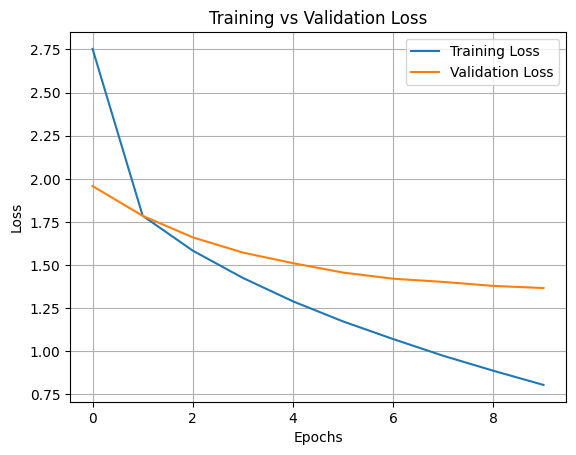

In [17]:

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
